# NLP, DS-поток
## Задание 3
### Transformers.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**
  * Работа с данными, токенизация, реализация метрики &mdash; 20 баллов;
  * Реализация модели &mdash; 20 баллов;
  * Реализация пайплайна &mdash; 60 баллов;
  * MLM &mdash; 50 баллов.


In [179]:
# Bot check

# HW_ID: ds_nlp3
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [180]:
!pip install transformers
!pip install datasets
!pip install torch==2.4.0
!pip install torchvision==0.19.0

In [181]:


from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import load_dataset

from transformers import BertTokenizer, BertConfig, DataCollatorWithPadding
from transformers import AdamW, BertModel, BertForSequenceClassification

from IPython.display import clear_output
%matplotlib inline

from pprint import pprint

sns.set(font_scale=1.2)
sns.set_style(style='whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

### Описание задачи
В этом домашнем задании мы будем работать с данными с [соревнования](https://boosters.pro/championship/HeadHunter/overview) от HeadHunter. Нам предстоит предсказать причины которые закодированы числами от 1 до 8, по которым отзыв на работадателя не проходит модерацию. Причин, по которым отзыв не прошёл модерацию может быть несколько. Если отзыв проходит модерацию, то вместо причины отказа нужно предсказывать 0. Значение 0 разрешается комбинировать с причинами отказа. 

Таким образом, мы имеем дело с задачей *multi-label классификации*. 
Самый простой и популярный способ работать с multi-label задачей классификации &mdash; перейти к бинарной. Для каждого класса мы ставим метку 1, если он присутствует в таргете, а 0 &mdash; иначе. В процессе обучения мы будем минимизировать бинарную кросс-энтропию.

В качестве целевой метрики будем использовать $F_1$-score с усреднением по сэмплам.

$$
F_1 = \frac{1}{n}\sum_{i=1}^n 2\frac{precision_i recall_i}{precision_i + recall_i},
$$
где $n$ &mdash; размер выборки, а $precision_i, recall_i$ &mdash; precision/recall для i-го объекта.

### Работа с данными

Загрузите обучающий датасет.

In [182]:
data = pd.read_csv("/kaggle/input/head-hunter/HeadHunter_train.csv")
data.head(5)

,review_id,city,position,positive,negative,salary_rating,team_rating,managment_rating,career_rating,workplace_rating,rest_recovery_rating,target
0,0,Ижевск,Кладовщик,Недавно устроился в ****** на должность кладов...,Повысить з/п,5,4,3,3,4,4,0
1,1,Москва,Руководитель проекта,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,4,4,4,1,1,1,8
2,2,Екатеринбург,Консультант,В нашем банке все по закону в плане зарплаты и...,Ничего,5,5,5,5,5,5,0
3,5,Санкт-Петербург,Оператор,Я в ****** около года работаю оператором. Норм...,Нет.,5,5,5,5,5,5,0
4,7,Москва,Инженер КИПиА,В принципе норм.Работать можно,Всегда есть к чему стремиться,4,5,4,2,5,2,8


Как можно увидеть, помимо положительного `positive` и отрицательного `negative` текста отзывов, мы также имеем некоторое количество категориальных признаков, с которыми мы пока не будем работать. Целевая переменная расположена в колонке `target` и представляет из себя строку, разделенную запятыми. 

Посмотрим, какие значения может принимать целевая переменная.

In [183]:
data["target"].unique()

array(['0', '8', '7', '1,8', '3,8', '6,8', '6', '3', '1', '1,6', '4,8',
       '5', '5,8', '1,5', '7,8', '4', '5,6', '1,4', '1,6,8', '1,7',
       '1,5,8', '1,3,8', '1,3', '1,4,6', '4,6', '1,3,5', '3,5,8', '1,5,6',
       '1,4,8', '1,2,6', '5,7', '3,5', '5,6,8', '1,3,6', '3,7', '2',
       '1,7,8', '3,6,8', '6,7', '4,6,8', '5,7,8', '3,6', '1,5,6,8',
       '3,5,7'], dtype=object)

Посмотрим на примеры отзывов, которые не прошли модерацию.

In [184]:
data[data["target"] == "5,8"]["positive"].values[13]

'Известная компания.....................................................................................................'

In [185]:
data[data["target"] == "3,8"]["positive"].values[29]

'Хужбвб влвлв в вщвлу у улыды ыыд'

Для дальнейшей работы избавьтесь от ненужных колонок, а также преобразуйте строковую целевую переменную в удобный для работы формат в виде матрицы, где каждому объекту будет сопоставлен вектор размерности 9, в котором на позиции $i$ будет стоять 1, если $i$ встречаетcя в текстовом поле `target`.



In [186]:
data_trunc = data[["positive", "negative", "target"]].copy()
data_trunc["target"] = data_trunc["target"].apply(lambda x: list(map(int, x.split(","))))

num_labels = 9  

def to_multilabel_vector(target_list):
    vec = np.zeros(num_labels, dtype=int)
    vec[target_list] = 1
    return vec

data_trunc["target_vector"] = data_trunc["target"].apply(to_multilabel_vector)
data_trunc = data_trunc.drop(columns=["target"])

data_trunc

,positive,negative,target_vector
0,Недавно устроился в ****** на должность кладов...,Повысить з/п,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"Расположение офиса, своего рода стабильность (...",Упростить процессы - все процессы ради процесс...,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,В нашем банке все по закону в плане зарплаты и...,Ничего,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Я в ****** около года работаю оператором. Норм...,Нет.,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,В принципе норм.Работать можно,Всегда есть к чему стремиться,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...
50871,Ни чего ни чего ни чего ни чего,Всё всё Всё всё Всё всё Всё всё Всё всё Всё всё,"[0, 0, 0, 1, 0, 0, 0, 0, 1]"
50872,Есть исключительно хорошие руководители.,Удачи хорошем управляющим в компании.,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
50873,Уютная столовая .раздевалка,График работы. Обучение сотрудников,"[0, 0, 0, 0, 0, 0, 0, 0, 1]"
50874,"Не соблюдают трудовой кодекс, переработки 7 д...",Рабская эксплуатация работников,"[0, 1, 0, 0, 0, 0, 0, 0, 0]"


Разделите выборку на обучающую и валидационную.

In [187]:
X = data_trunc[["positive", "negative"]]
y = np.vstack(data_trunc["target_vector"].values)

train_data, val_data, train_labels, val_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [188]:
print(f"Train shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Val shape: {val_data.shape}, Val labels shape: {val_labels.shape}")

Train shape: (40700, 2), Train labels shape: (40700, 9)
Val shape: (10176, 2), Val labels shape: (10176, 9)


### Токенизация и реализация метрики качества

Теперь реализуем вышеупомянутую метрику, а именно $F_1$-score с усреднением по сэмплам. Подумайте, как поступить, если для какого-то из объектов $precision=recall=0$?

In [189]:
def calculate_f1_score(preds, targets):
    """
    Функция подсчета F1-score с усреднением по сэмплам.

    :param preds: np.array размерности (n, 9), предсказания в виде бинарной метки 0/1 для каждого класса.
    :param targets: np.array размерности (n, 9), истинные бинарные таргеты.
    :return: средний F1-score по сэмплам.
    """
    f1_scores = []
    for i in range(preds.shape[0]):
        tp = np.sum((preds[i] == 1) & (targets[i] == 1))
        fp = np.sum((preds[i] == 1) & (targets[i] == 0))
        fn = np.sum((preds[i] == 0) & (targets[i] == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        f1 = 2 * precision * recall / (precision + recall + 1e-15) if (precision + recall) > 0 else 0.0
        f1_scores.append(f1)
    
    return np.mean(f1_scores)


В этом задании предлагается использовать библиотеку `transformers`, а значит позаботиться о токенизации надо заранее, ведь токенизаторы у разных моделей могут отличаться. Вы можете использовать любую модель, которая умеет работать с русским языком. Рекомендуем обратить внимания на следующие:

* [ruBert-base](https://huggingface.co/sberbank-ai/ruBert-base)
* [rubert-base-cased](https://huggingface.co/DeepPavlov/rubert-base-cased)
* [distilrubert-base-cased-conversational](https://huggingface.co/DeepPavlov/distilrubert-base-cased-conversational)
* [rubert-tiny](https://habr.com/ru/post/562064/)
* [ruRoberta-large](https://huggingface.co/sberbank-ai/ruRoberta-large/)

Учтите, что некоторые из моделей могут потребовать значительных ресурсов GPU. Для обучения рекомендуем использовать Colab или Kaggle. Самая легкая и быстрая модель из перечисленных &mdash; это `rubert-tiny`, можете для простоты использовать ее.

На вход модели предлагается подавать последовательность следующего вида: `[CLS] positive [SEP] negative [SEP]`, где `positive` и `negative` &mdash; тексты положительной и отрицательной части отзыва, разделенные спец. токеном `[SEP]`, получить который можно через `tokenizer.sep_token`. То есть мы сразу подаем в энкодер тексты обеих частей отзыва и пытаемся предсказать результат модерации. После применения энкодера скрытое состояние, соответствующее токену `[CLS]`, будет содержать информацию о содержании отзыва. После этого, просто используя линейный слой, мы сможем сделать предсказание для 9 классов.

In [190]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

# соединим две части отзыва
# токен CLS и второй SEP добавит токенизатор
train_concatenated = [
    str(elem["positive"]) + " " + tokenizer.sep_token + " " + str(elem["negative"])
    for _, elem in train_data.iterrows()
]

val_concatenated = [
    str(elem["positive"]) + " " + tokenizer.sep_token + " " + str(elem["negative"])
    for _, elem in val_data.iterrows()
]

Создадим датасет, используя `datasets.Dataset` и метод `.from_dict(...)`.

In [191]:
train_dataset = Dataset.from_dict({
    "text": train_concatenated,  # тексты
    "labels": train_labels       # метки
})

val_dataset = Dataset.from_dict({
    "text":val_concatenated,
    "labels": val_labels
})

Наш датасет содержит тексты и метки к ним. Для дальнешей работы тексты нужно токенизировать, для этого воспользуемся методом `map` у датасета.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x500 with 0 Axes>

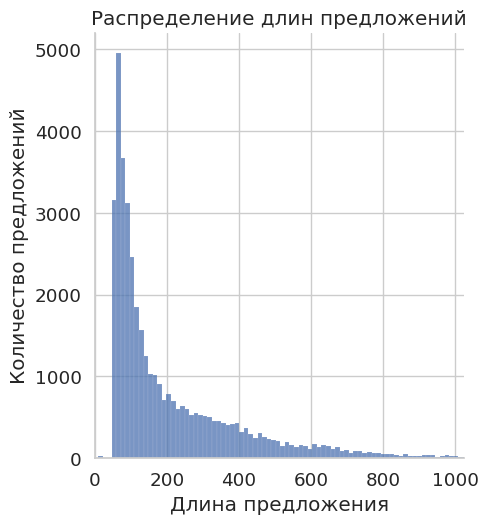

In [192]:
lens = [len(x["text"]) for x in train_dataset]

plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlim([0, 1024])
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

По графику видно, что можно можно ограничиться первыми  512 словами.

In [193]:
train_dataset = train_dataset.map(# применяем функцию к каждому элементу датасета
    lambda elem: tokenizer(
        elem["text"],             #  токенизируем поле text
        add_special_tokens=True,  #  автоматически добавляем CLS, SEP токены
        truncation=True,          #  обрезаем ли последовательность
        max_length=512          #  ограничение на длину, надо выставить разумно? :)
    )
)

val_dataset = val_dataset.map(# применяем функцию к каждому элементу датасета
    lambda elem: tokenizer(
        elem["text"],             #  токенизируем поле text
        add_special_tokens=True,  #  автоматически добавляем CLS, SEP токены
        truncation=True,          #  обрезаем ли последовательность
        max_length=512          #  ограничение на длину, надо выставить разумно? :)
    )
)

Map:   0%|          | 0/40700 [00:00<?, ? examples/s]

Map:   0%|          | 0/10176 [00:00<?, ? examples/s]

Посмотрим на элемент нашего датасета.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x500 with 0 Axes>

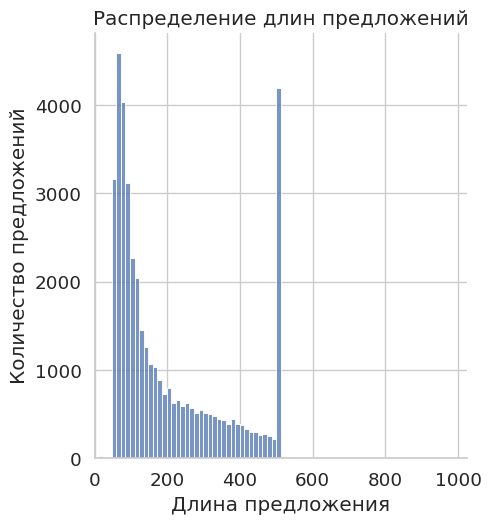

In [194]:
lens = np.array([len(x["text"]) for x in train_dataset])

lens[lens > 512] = 512

plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlim([0, 1024])
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

In [195]:
train_dataset[7]

{'text': 'Ничего. Все плохо, мне ничего не нравится [SEP] Повысить зарплату и не вычитать за все подряд Не орать на сотрудников и не оскорблять',
 'labels': [0, 0, 0, 0, 0, 0, 1, 0, 1],
 'input_ids': [2,
  293,
  5158,
  20836,
  18,
  9057,
  327,
  1580,
  13718,
  16,
  20284,
  20125,
  769,
  325,
  13266,
  14209,
  3,
  1499,
  4960,
  27266,
  650,
  870,
  1231,
  23489,
  320,
  769,
  26629,
  25580,
  650,
  2749,
  28607,
  6226,
  326,
  7154,
  1090,
  548,
  28618,
  320,
  769,
  24485,
  23949,
  28833,
  1348,
  3],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  

Как видим, помимо `input_ids`, которые отправятся на вход модели, у нас так же имеется `attention_mask`, а также в зависимости от модели могут быть `token_type_ids` &mdash; некоторые модели используют для задачи **NSP**.

Вообще говоря, уже на этапе токенизации мы могли бы дополнить паддингом до максимальной длины наши последовательности, это можно сделать при вызове токенизатора, используя параметр `padding`. Однако у это подхода есть недостатки, поэтому эффективнее будет выполнить паддинг в даталоадере, на этапе формирования батча, тем самым дополнив все последовательности по длине до максимальной длины в батче.

Подробнее о токенизаторах в `transformers` можно почитать по [ссылке](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/tokenizer).

Посмотрим, как расположены спец токены:

In [196]:
tokenizer.decode(train_dataset[6]["input_ids"])

'[CLS] надежная компания. порядки здесь строгие, что хорошо. если работать исправно и не халявить то можно и премию отличную заработать.. официальное трудоустройство и полный соц пакет [SEP] к компании у меня претензий никаких нет. [SEP]'

Избавимся от теперь ненужного поля `text`.

In [197]:
train_dataset_mlm = train_dataset
val_dataset_mlm = val_dataset

train_dataset = train_dataset.remove_columns("text")
val_dataset = val_dataset.remove_columns("text")

### Модель

Реализуйте класс модели. В качестве классификатора используйте линейный слой, в который можно подать, например, эмбеддинг CLS-токена с последнего слоя, который можно получить следующим образом:



```
output = bert(input)
cls_token = output.last_hidden_state[:, 0, :]
logits = classifier(cls_token)
```



In [198]:
class Model(nn.Module):
    def __init__(self, pretrained_name="cointegrated/rubert-tiny", num_labels=9, device="cpu"):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_name)
        self.drop = nn.Dropout(p=0.1)

        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

        self.device = device
    
    def forward(self, batch):
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)
        
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = output.last_hidden_state[:, 0, :]
        
        output = self.drop(output)
        logits = self.fc(output)
        
        return logits

Проверьте работоспособность модели простым тестом на размерность. В зависимости от реализации метода forward, код ниже стоит поменять, сохранив смысл.

In [199]:
batch_size = 8
dummy_input = {"input_ids" : torch.randint(0, 20000, (batch_size, 512)),
              "attention_mask" : torch.randint(0, 1, (batch_size, 512)),}
model = Model()

assert model(dummy_input).shape == (batch_size, 9)

### Пайплайн обучения

1. Реализуйте пайплайн обучения и обучите модель. Попробуйте по желанию воспользоваться `Trainer`-ом и библиотеки `transformers`. Вам могут помочь примеры [здесь](https://huggingface.co/docs/transformers/training), [здесь](https://huggingface.co/learn/nlp-course/chapter3/3) и [здесь](https://github.com/huggingface/transformers/tree/main/examples/pytorch/text-classification). Учтите, что у нас задача *multi-label классификации*, которую мы свели к бинарной классификации нескольких меток, а значит нужно использовать **BCE-loss**. 
2. Cначала обучите только последний линейный слой, заморозив веса языковой модели, а затем всю модель целиком. Посчитайте качество на валидационной выборке и сравните результаты. 

Подумайте, как стоит выбирать порог для бинарной классификации. Что делать, если мы не предсказали никакой класс? Что можно сказать о результатах? 



В случае использования `transformers.Trainer` в него можно передать датасеты, а также `data collator` &mdash; объект, который непосредственно формирует батч по списку объектов из датасета. Обычно, в процессе формирования батча `data collator` может выполнять некоторой препроцессинг, например, паддинг или маскирование токенов в задаче **MLM**.

Воспользуемся простым data collator-ом для паддинга наших текстов. Создадим даталоадеры для случая самописного кода обучения.

In [200]:
batch_size = 128

data_collator = DataCollatorWithPadding(tokenizer)
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=data_collator)

val_loader = DataLoader(val_dataset, 
                          batch_size=batch_size,
                          shuffle=False,
                          collate_fn=data_collator)


Посмотрим на батч данных.

In [201]:
next(iter(train_loader))

{'labels': tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]]), 'input_ids': tensor([[    2,   297,   764,  ...,     0,     0,     0],
        [    2,   296, 15984,  ...,     0,     0,     0],
        [    2,   301, 26923,  ...,     0,     0,     0],
        ...,
        [    2,   311,  2225,  ...,     0,     0,     0],
        [    2,   299, 17377,  ...,     0,     0,     0],
        [    2,   293,  5158,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 

In [202]:
def train(
    model,
    optimizer,
    criterion,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    Возвращает модель и словарь с метриками при обучении.
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_f1 = 0
        val_loss = 0
        val_f1 = 0

        start_time = time.time()

        model.train(True)  # устанавливаем поведение dropout / batch_norm в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for batch in tqdm(train_batch_gen, desc="training"):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(
                batch
            )
            loss = criterion(logits, batch["labels"].to(device).float())  # Преобразование в float
            # backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Cохраним лосс и посчитаем F1-метрику
            train_loss += loss.item()
            y_pred = (torch.sigmoid(logits) > 0.5).detach().cpu().numpy()
            y_true = batch["labels"].numpy()
            train_f1 += calculate_f1_score(y_pred, y_true)

        # Подсчитываем лоссы и сохраняем в "историю"
        train_loss /= len(train_batch_gen)
        train_f1 /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)

        model.train(False)  # устанавливаем поведение dropout / batch_norm в тестирование

        # Полный проход по валидации
        for batch in tqdm(val_batch_gen, desc="evaluation"):
            # При использовании .no_grad() модель не будет считать и хранить градиенты.
            # Это ускорит процесс предсказания меток для валидационных данных.
            with torch.no_grad():
                logits = model(
                    batch
                )
                loss = criterion(logits, batch["labels"].to(device).float())  # Преобразование в float

            val_loss += loss.item()

            # Применяем функцию max к каждому логиту из батча
            # Функция max возвращает две величины: значения и индексы
            # Выбираем индексы
            y_pred = (torch.sigmoid(logits) > 0.5).detach().cpu().numpy()
            y_true = batch["labels"].numpy()
            val_f1 += calculate_f1_score(y_pred, y_true)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss /= len(val_batch_gen)
        val_f1 /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['f1']['val'].append(val_f1)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training F1-score: \t\t\t{:.2f} %".format(train_f1 * 100))
        print("  validation F1-score: \t\t\t{:.2f} %".format(val_f1 * 100))

    return model, history

In [203]:
def evaluate_model_on_test_set(model, test_loader, device):
    """
    Функция для оценки модели на тестовом наборе данных, вычисляющая F1-score
    с использованием функции calculate_f1_score для многоклассовой классификации.

    :param model: модель, которая будет оцениваться
    :param test_loader: DataLoader для тестового набора
    :param device: устройство (cpu или cuda), на котором будет работать модель
    :return: F1-score на тестовом наборе
    """
    model.eval()
    test_preds, test_labels = [], []

    for batch in tqdm(test_loader, desc="testing"):
        with torch.no_grad():
            logits = model(batch)

        y_pred = (torch.sigmoid(logits) > 0.5).detach().cpu().numpy()
        test_preds.extend(y_pred)
        test_labels.extend(batch["labels"].numpy())

    test_f1_score = calculate_f1_score(np.array(test_preds), np.array(test_labels))

    print(f"F1-score: {test_f1_score:.2f}%")

    return test_f1_score


Сначала обучим модель, заморозив веса.

In [204]:
model = Model(num_labels=9, device=device)
model.to(device)

for param in model.bert.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model, history_stage1 = train(model, optimizer, criterion, train_loader, val_loader, num_epochs=5)

training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 of 5 took 60.359s
  training loss (in-iteration): 	0.184858
  validation loss (in-iteration): 	0.143514
  training F1-score: 			71.46 %
  validation F1-score: 			74.90 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2 of 5 took 60.948s
  training loss (in-iteration): 	0.142516
  validation loss (in-iteration): 	0.137521
  training F1-score: 			74.38 %
  validation F1-score: 			74.94 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3 of 5 took 60.850s
  training loss (in-iteration): 	0.138133
  validation loss (in-iteration): 	0.134460
  training F1-score: 			74.61 %
  validation F1-score: 			75.93 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4 of 5 took 61.266s
  training loss (in-iteration): 	0.135966
  validation loss (in-iteration): 	0.132758
  training F1-score: 			74.82 %
  validation F1-score: 			75.47 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5 of 5 took 61.197s
  training loss (in-iteration): 	0.134651
  validation loss (in-iteration): 	0.132310
  training F1-score: 			75.06 %
  validation F1-score: 			75.69 %


Посмотрим на итоговый результат

In [205]:
evaluate_model_on_test_set(model, val_loader, device)

testing:   0%|          | 0/80 [00:00<?, ?it/s]

F1-score: 0.76%


0.756852725366876

Теперь разморозим веса и дообучим модель

In [206]:
for param in model.bert.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model, history_stage2 = train(model, optimizer, criterion, train_loader, val_loader, num_epochs=5)

training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 of 5 took 157.405s
  training loss (in-iteration): 	0.121970
  validation loss (in-iteration): 	0.112836
  training F1-score: 			77.83 %
  validation F1-score: 			80.26 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2 of 5 took 157.799s
  training loss (in-iteration): 	0.109176
  validation loss (in-iteration): 	0.110455
  training F1-score: 			80.09 %
  validation F1-score: 			80.62 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3 of 5 took 156.409s
  training loss (in-iteration): 	0.101356
  validation loss (in-iteration): 	0.109667
  training F1-score: 			81.46 %
  validation F1-score: 			80.72 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4 of 5 took 156.732s
  training loss (in-iteration): 	0.095232
  validation loss (in-iteration): 	0.109361
  training F1-score: 			82.55 %
  validation F1-score: 			81.36 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5 of 5 took 157.069s
  training loss (in-iteration): 	0.089786
  validation loss (in-iteration): 	0.109381
  training F1-score: 			83.61 %
  validation F1-score: 			80.96 %


Посмотрим на f1-score

In [207]:
evaluate_model_on_test_set(model, val_loader, device)

testing:   0%|          | 0/80 [00:00<?, ?it/s]

F1-score: 0.81%


0.8094896488469596

### MLM pretraining

Попробуйте улучшить качество, предварительно обучив выбранную модель на задачу **MLM** на обучающем датасете. Будет достаточно 1-2 эпох. Воспользуйтесь [примерами](https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling) из репозитория. Правильно организовав файл с обучающими данными, остается лишь воспользоваться готовым скриптом.

In [208]:
!git clone https://github.com/huggingface/transformers
!pip install -e .

Cloning into 'transformers'...
remote: Enumerating objects: 261147, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 261147 (delta 48), reused 37 (delta 37), pack-reused 261063 (from 3)
Receiving objects: 100% (261147/261147), 271.73 MiB | 32.13 MiB/s, done.
Resolving deltas: 100% (193040/193040), done.
Obtaining file:///root
ERROR: file:///root does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [209]:
train_dataset_mlm.to_json('/kaggle/working/train_dataset.json')
val_dataset_mlm.to_json('/kaggle/working/val_dataset.json')

Creating json from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

18712662

In [210]:
!pip install evaluate

In [211]:
!python /kaggle/working/transformers/examples/pytorch/language-modeling/run_mlm.py \
    --model_name_or_path cointegrated/rubert-tiny \
    --train_file /kaggle/working/train_dataset.json \
    --validation_file /kaggle/working/val_dataset.json \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 16 \
    --do_train \
    --do_eval \
    --overwrite_output_dir \
    --output_dir /kaggle/working/results \
    --report_to none

2025-03-14 17:45:58.601876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 17:45:58.625567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 17:45:58.632820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using custom data configuration default-bff88ecc6940565c
Loading Dataset Infos from /usr/local/lib/python3.10/dist-packages/datasets/packaged_modules/json
Generating dataset json (/root/.cache/huggingface/datasets/json/default-bff88ecc6940565c/0.0.0/f4e89e8750d5d5ffbef2c078bf0ddfedef29dc2faff52a6255cf513c05eb1092)
Checksum Computation took 0.0 min
Generating trai

Обучите модель, полученную после процедуры **MLM** претрейна. Улучшилось ли качество?

In [212]:
model = Model(pretrained_name = "/kaggle/working/results", num_labels=9, device="cuda")

Some weights of BertModel were not initialized from the model checkpoint at /kaggle/working/results and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [213]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
model.to(device)
model, history_stage1 = train(model, optimizer, criterion, train_loader, val_loader, num_epochs=10)

training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1 of 10 took 155.510s
  training loss (in-iteration): 	0.531337
  validation loss (in-iteration): 	0.381872
  training F1-score: 			45.64 %
  validation F1-score: 			65.04 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2 of 10 took 157.278s
  training loss (in-iteration): 	0.312395
  validation loss (in-iteration): 	0.260676
  training F1-score: 			67.98 %
  validation F1-score: 			69.46 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3 of 10 took 154.975s
  training loss (in-iteration): 	0.234891
  validation loss (in-iteration): 	0.212291
  training F1-score: 			70.34 %
  validation F1-score: 			70.56 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4 of 10 took 156.034s
  training loss (in-iteration): 	0.201246
  validation loss (in-iteration): 	0.188793
  training F1-score: 			71.23 %
  validation F1-score: 			71.45 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5 of 10 took 157.034s
  training loss (in-iteration): 	0.183633
  validation loss (in-iteration): 	0.175611
  training F1-score: 			71.74 %
  validation F1-score: 			72.00 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6 of 10 took 154.192s
  training loss (in-iteration): 	0.173547
  validation loss (in-iteration): 	0.167336
  training F1-score: 			72.25 %
  validation F1-score: 			72.44 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7 of 10 took 156.285s
  training loss (in-iteration): 	0.166870
  validation loss (in-iteration): 	0.161718
  training F1-score: 			72.50 %
  validation F1-score: 			72.81 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8 of 10 took 153.716s
  training loss (in-iteration): 	0.162363
  validation loss (in-iteration): 	0.157638
  training F1-score: 			72.80 %
  validation F1-score: 			73.08 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9 of 10 took 157.387s
  training loss (in-iteration): 	0.158602
  validation loss (in-iteration): 	0.154587
  training F1-score: 			73.00 %
  validation F1-score: 			73.52 %


training:   0%|          | 0/318 [00:00<?, ?it/s]

evaluation:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10 of 10 took 157.452s
  training loss (in-iteration): 	0.156055
  validation loss (in-iteration): 	0.152093
  training F1-score: 			73.25 %
  validation F1-score: 			73.86 %


In [214]:
evaluate_model_on_test_set(model, val_loader, device)

testing:   0%|          | 0/80 [00:00<?, ?it/s]

F1-score: 0.74%


0.7382566823899368

[Здесь](https://habr.com/ru/company/alfa/blog/669522/) можно прочитать подход от участников, занявших второе место в этом соревновании.

**Выводы**

Мы смогли дообучить модель предсказывать результаты отказа в принятии отзыва.

Обучение с замороженными весами слоев самой модели происходило достаточно быстро и смогли получить f1-score равный 0.75. 

Дообучение с размороженными весами дало f1-score почти 0.81

Пародоксально, но дообучение с MLM, напротив ухудшило качество до ~0.73. Возможно это связано в видом датасета или недостаточным количеством эпох обучения